## Weather observations and new influenza infections

The goal of this project is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2009-2019)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2019).

The data to be used can be found in the subdirectory named `data`. 

Throughout this project, we will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

Also, we will:
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` and `seaborn` to visually analyse data,
 * use `scikit-learn` to build prediction models.

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import model_selection
import time

## Load Data

### Weather observations

As a first step, we will implement the method `load_weather_data()`, which will read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- from the `date` column we will create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day`
- make sure that all columns are appropriately typed
- make sure that we load all the data (2009-2019)

In [2]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    
    data_files = glob.glob("./data/weather/*")
    data_list = [pd.read_csv(f, sep=";") for f in data_files]
    weather_data = pd.concat(data_list, axis=0, ignore_index=True)
    weather_data["year"] = pd.to_datetime(weather_data.date).dt.year
    weather_data["month"] = pd.to_datetime(weather_data.date).dt.month
    weather_data["week"] = pd.to_datetime(weather_data.date).dt.isocalendar().week
    weather_data["day"] = pd.to_datetime(weather_data.date).dt.day
    weather_data.set_index(["year", "month", "week", "day"], inplace=True)
    weather_data.sort_index(inplace=True)
    return weather_data

data_weather = load_weather_data()

It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.

In [3]:
# testing the shape of our resulting dataframe
assert data_weather.shape == (4017, 17)

### Question

Which combination of year+week has the highest number of entries? What causes this number?

In [4]:
year = 0 
month = 0
year_week_data = data_weather.groupby(["year", "week"]).count()
year = year_week_data[year_week_data.date == year_week_data.date.max()].index.get_level_values("year").tolist()
month = year_week_data[year_week_data.date == year_week_data.date.max()].index.get_level_values("week").tolist()
display(year, month)

[2011, 2012, 2012, 2013, 2014, 2017, 2018, 2019]

[52, 1, 52, 1, 1, 52, 1, 1]

For week 52, we are getting these values because the final week of each year happens to continue also in the next year therefore the week number e.g. 52 will be at the beginning of the year (belonging to the previous year) and  at the end (belonging to the current year). 

For week 1, since we are using isocalendar() and knowing that an ISO year perfectly starts on a Monday, we have cases when week 1 of the next year starts at the end of the previous year therefore when grouping we will get 8 entries for week 1 within a year.

### Influenza infections

Load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- remove rows with missing infection counts

In [5]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    
    data_path = "./data/influenza/influenza.csv"
    influenza_data = pd.read_csv(data_path, usecols=["Jahr", "Kalenderwoche", "Neuerkrankungen pro Woche"])
    # remove . Woche from each record in Kalenderwoche column and convert it to numeric type
    influenza_data["Kalenderwoche"] = pd.to_numeric(influenza_data["Kalenderwoche"].str.replace(". Woche", ""))
    influenza_data.rename(columns={"Jahr": "year",
                                   "Kalenderwoche": "week",
                                   "Neuerkrankungen pro Woche": "weekly_infections"}, inplace=True)
    influenza_data.set_index(["year", "week"], inplace=True)
    influenza_data['weekly_infections'].replace('-', np.NaN, inplace=True)
    influenza_data = influenza_data[influenza_data["weekly_infections"].notna()]
    influenza_data["weekly_infections"] = pd.to_numeric(influenza_data["weekly_infections"])
    return influenza_data

data_influenza = load_influenza_data()

In [6]:
# testing the shape of our resulting dataframe
assert data_influenza.shape == (258, 1)

### Question
Which combination of year+week shows the highest number of infections?

In [7]:
year = 0 
month = 0
year = data_influenza[data_influenza["weekly_infections"] == data_influenza["weekly_infections"].max()].index.get_level_values("year").tolist()[0]
month = data_influenza[data_influenza["weekly_infections"] == data_influenza["weekly_infections"].max()].index.get_level_values("week").tolist()[0]
display(year, month)

2017

1

## Handling Missing Values

By taking a closer look at the data, we noticed that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, we talked to the metereologist that compiled the data. She told us that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she said that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

We will first check how many missing values we have in our data and also where are those missing values distributed

In [8]:
print(data_weather.isna().sum(), "\n\nTotal missing values:", data_weather.isna().sum().sum())

date                0
skyCover_7h         0
skyCover_14h        0
skyCover_19h        0
temp_7h           198
temp_14h          198
temp_19h          198
temp_dailyMean      0
temp_dailyMax       0
temp_dailyMin       0
hum_7h            198
hum_14h           198
hum_19h           198
windBeauf_7h        0
windBeauf_14h       0
windBeauf_19h       0
precip              0
dtype: int64 

Total missing values: 1188


To check the plausibility of the hypothesis that the temperature readings are missing because someone forgot to record them, we plot the distribution of values for *temp_dailyMean*, *skyCover*, *windBeauf* and *humidity* when temperature is missing versus when temperature is not missing. This way we check if missing temperature values are missing with some certain pattern or completely at random

C:\Users\blend\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\blend\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


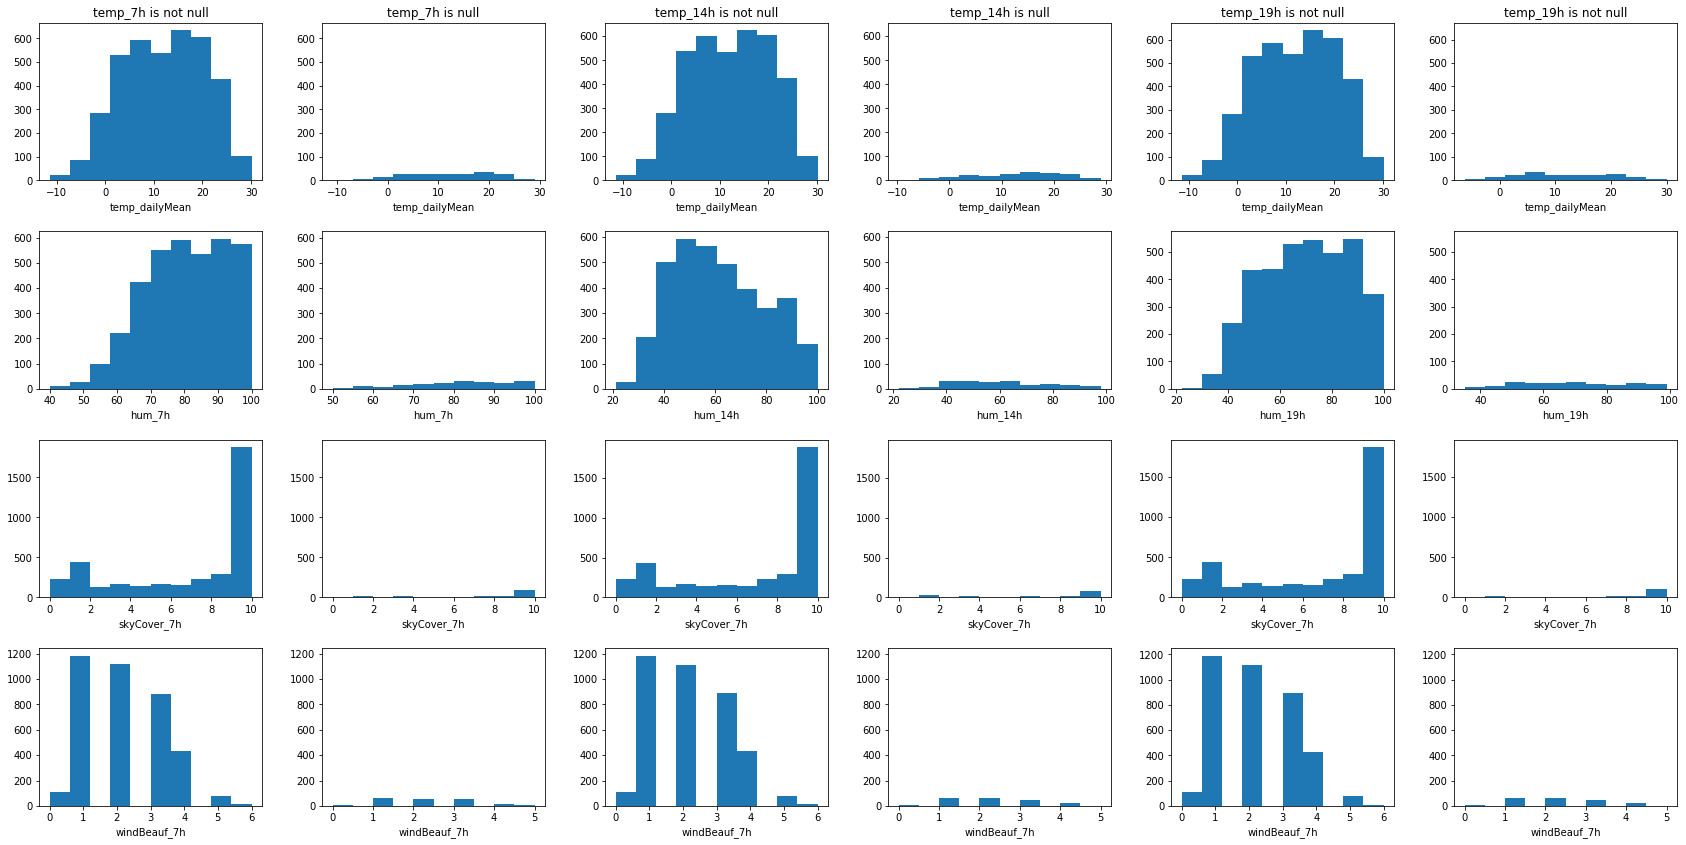

In [9]:
fig, ax = plt.subplots(4,6, figsize=(24,12))
fig.tight_layout(pad=3.0)
ax[0, 0].hist(data_weather[data_weather.temp_7h.notnull()].temp_dailyMean)
ax[0, 0].set_title('temp_7h is not null')
ax[0, 0].set_xlabel('temp_dailyMean')
y_min, y_max = ax[0, 0].get_ylim()
ax[0, 1].hist(data_weather[data_weather.temp_7h.isna()].temp_dailyMean)
ax[0, 1].set_title('temp_7h is null')
ax[0, 1].set_xlabel('temp_dailyMean')
ax[0, 1].set_ylim(y_min, y_max)
ax[1, 0].hist(data_weather[data_weather.temp_7h.notnull()].hum_7h)
ax[1, 0].set_xlabel('hum_7h')
y_min, y_max = ax[1, 0].get_ylim()
ax[1, 1].hist(data_weather[data_weather.temp_7h.isna()].hum_7h)
ax[1, 1].set_xlabel('hum_7h')
ax[1, 1].set_ylim(y_min, y_max)
ax[2, 0].hist(data_weather[data_weather.temp_7h.notnull()].skyCover_7h)
ax[2, 0].set_xlabel('skyCover_7h')
y_min, y_max = ax[2, 0].get_ylim()
ax[2, 1].hist(data_weather[data_weather.temp_7h.isna()].skyCover_7h)
ax[2, 1].set_xlabel('skyCover_7h')
ax[2, 1].set_ylim(y_min, y_max)
ax[3, 0].hist(data_weather[data_weather.temp_7h.notnull()].windBeauf_7h)
ax[3, 0].set_xlabel('windBeauf_7h')
y_min, y_max = ax[3, 0].get_ylim()
ax[3, 1].hist(data_weather[data_weather.temp_7h.isna()].windBeauf_7h)
ax[3, 1].set_xlabel('windBeauf_7h')
ax[3, 1].set_ylim(y_min, y_max)
ax[0, 2].hist(data_weather[data_weather.temp_14h.notnull()].temp_dailyMean)
ax[0, 2].set_title('temp_14h is not null')
ax[0, 2].set_xlabel('temp_dailyMean')
y_min, y_max = ax[0, 2].get_ylim()
ax[0, 3].hist(data_weather[data_weather.temp_14h.isna()].temp_dailyMean)
ax[0, 3].set_title('temp_14h is null')
ax[0, 3].set_xlabel('temp_dailyMean')
ax[0, 3].set_ylim(y_min, y_max)
ax[1, 2].hist(data_weather[data_weather.temp_14h.notnull()].hum_14h)
ax[1, 2].set_xlabel('hum_14h')
y_min, y_max = ax[1, 2].get_ylim()
ax[1, 3].hist(data_weather[data_weather.temp_14h.isna()].hum_14h)
ax[1, 3].set_xlabel('hum_14h')
ax[1, 3].set_ylim(y_min, y_max)
ax[2, 2].hist(data_weather[data_weather.temp_14h.notnull()].skyCover_7h)
ax[2, 2].set_xlabel('skyCover_7h')
y_min, y_max = ax[2, 2].get_ylim()
ax[2, 3].hist(data_weather[data_weather.temp_14h.isna()].skyCover_7h)
ax[2, 3].set_xlabel('skyCover_7h')
ax[2, 3].set_ylim(y_min, y_max)
ax[3, 2].hist(data_weather[data_weather.temp_14h.notnull()].windBeauf_7h)
ax[3, 2].set_xlabel('windBeauf_7h')
y_min, y_max = ax[3, 2].get_ylim()
ax[3, 3].hist(data_weather[data_weather.temp_14h.isna()].windBeauf_7h)
ax[3, 3].set_xlabel('windBeauf_7h')
ax[3, 3].set_ylim(y_min, y_max)
ax[0, 4].hist(data_weather[data_weather.temp_19h.notnull()].temp_dailyMean)
ax[0, 4].set_title('temp_19h is not null')
ax[0, 4].set_xlabel('temp_dailyMean')
y_min, y_max = ax[0, 4].get_ylim()
ax[0, 5].hist(data_weather[data_weather.temp_19h.isna()].temp_dailyMean)
ax[0, 5].set_title('temp_19h is not null')
ax[0, 5].set_xlabel('temp_dailyMean')
ax[0, 5].set_ylim(y_min, y_max)
ax[1, 4].hist(data_weather[data_weather.temp_19h.notnull()].hum_19h)
ax[1, 4].set_xlabel('hum_19h')
y_min, y_max = ax[1, 4].get_ylim()
ax[1, 5].hist(data_weather[data_weather.temp_19h.isna()].hum_19h)
ax[1, 5].set_xlabel('hum_19h')
ax[1, 5].set_ylim(y_min, y_max)
ax[2, 4].hist(data_weather[data_weather.temp_19h.notnull()].skyCover_7h)
ax[2, 4].set_xlabel('skyCover_7h')
y_min, y_max = ax[2, 4].get_ylim()
ax[2, 5].hist(data_weather[data_weather.temp_19h.isna()].skyCover_7h)
ax[2, 5].set_xlabel('skyCover_7h')
ax[2, 5].set_ylim(y_min, y_max)
ax[3, 4].hist(data_weather[data_weather.temp_19h.notnull()].windBeauf_7h)
ax[3, 4].set_xlabel('windBeauf_7h')
y_min, y_max = ax[3, 4].get_ylim()
ax[3, 5].hist(data_weather[data_weather.temp_19h.isna()].windBeauf_7h)
ax[3, 5].set_xlabel('windBeauf_7h')
ax[3, 5].set_ylim(y_min, y_max)
plt.show()

In [10]:
display(data_weather[(data_weather.hum_7h.isna() & ~data_weather.hum_14h.isna()) | 
                     (data_weather.hum_7h.isna() & ~data_weather.hum_19h.isna()) | 
                     (data_weather.hum_14h.isna() & ~data_weather.hum_19h.isna())])

,,,,date,skyCover_7h,skyCover_14h,skyCover_19h,temp_7h,temp_14h,temp_19h,temp_dailyMean,temp_dailyMax,temp_dailyMin,hum_7h,hum_14h,hum_19h,windBeauf_7h,windBeauf_14h,windBeauf_19h,precip
year,month,week,day,,,,,,,,,,,,,,,,,


We can see that humidity values for `7h`, `14h` and `19h` are always together as `NaN`.

To check the plausibility of the hypothesis that the humidity sensor is less reliable in hot weather we see average daily temperature when humidity is missing:

In [11]:
data_weather[data_weather.hum_7h.isna()]["temp_dailyMean"].describe()

count    198.000000
mean      25.142929
std        2.538401
min       17.900000
25%       23.700000
50%       25.150000
75%       27.000000
max       30.100000
Name: temp_dailyMean, dtype: float64

Since the minimum value of the daily average temperature when humidity is missing is `17.9`, we can confirm that the hypothesis is correct since in all the cases when humidity is missing, weather is hot.

In [12]:
data_weather.corr()

,skyCover_7h,skyCover_14h,skyCover_19h,temp_7h,temp_14h,temp_19h,temp_dailyMean,temp_dailyMax,temp_dailyMin,hum_7h,hum_14h,hum_19h,windBeauf_7h,windBeauf_14h,windBeauf_19h
skyCover_7h,1.000000,0.589425,0.436262,-0.197135,-0.289290,-0.271027,-0.298768,-0.373498,-0.186538,0.312265,0.547949,0.470897,0.209535,0.049127,0.088893
skyCover_14h,0.589425,1.000000,0.635088,-0.190088,-0.322897,-0.270769,-0.318603,-0.392188,-0.207131,0.204971,0.592830,0.471133,0.222361,0.075861,0.130180
skyCover_19h,0.436262,0.635088,1.000000,-0.135531,-0.214989,-0.179703,-0.211584,-0.263651,-0.133128,0.178753,0.460625,0.404214,0.129242,0.048094,0.128012
temp_7h,-0.197135,-0.190088,-0.135531,1.000000,0.526493,0.551648,0.742749,0.721900,0.739804,-0.279892,-0.320556,-0.327294,-0.066813,-0.007616,-0.000514
temp_14h,-0.289290,-0.322897,-0.214989,0.526493,1.000000,0.538679,0.721216,0.733732,0.674301,-0.240033,-0.459900,-0.399764,-0.211343,-0.045960,-0.043574
temp_19h,-0.271027,-0.270769,-0.179703,0.551648,0.538679,1.000000,0.726889,0.729362,0.693419,-0.235853,-0.392021,-0.397913,-0.170105,-0.035048,-0.012220
temp_dailyMean,-0.298768,-0.318603,-0.211584,0.742749,0.721216,0.726889,1.000000,0.986803,0.976257,-0.323219,-0.487695,-0.451535,-0.161323,-0.038295,-0.027352
temp_dailyMax,-0.373498,-0.392188,-0.263651,0.721900,0.733732,0.729362,0.986803,1.000000,0.928317,-0.337846,-0.570548,-0.517376,-0.221805,-0.047301,-0.038813
temp_dailyMin,-0.186538,-0.207131,-0.133128,0.739804,0.674301,0.693419,0.976257,0.928317,1.000000,-0.288951,-0.353263,-0.341916,-0.073992,-0.024920,-0.011064
hum_7h,0.312265,0.204971,0.178753,-0.279892,-0.240033,-0.235853,-0.323219,-0.337846,-0.288951,1.000000,0.583686,0.595612,-0.249779,-0.199845,-0.117019


In [13]:
def handle_missingValues(incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    
    incomplete_data[["temp_7h", "temp_14h", "temp_19h"]] = incomplete_data[["temp_7h", "temp_14h", "temp_19h"]].interpolate(limit_direction='backward')
    X = incomplete_data[incomplete_data['hum_7h'].notnull()].drop(["date", "precip", "hum_7h", "hum_14h", "hum_19h"], axis=1)
    cols = ["hum_7h", "hum_14h", "hum_19h"]
    for col in cols:
        y = incomplete_data[incomplete_data[col].notnull()][col].values
        # Step 1: Train the machine learning algorithm
        linreg = LinearRegression()
        linreg.fit(X, y)
        # Step 2: Predict the missing values
        predicted = linreg.predict(incomplete_data[incomplete_data[col].isna()].
                                   drop(["date", "precip", "hum_7h", "hum_14h", "hum_19h"], axis=1))
        # Step 3: Apply prediction 
        incomplete_data.loc[incomplete_data[col].isna(), col] = predicted
    
    complete_data = incomplete_data
    
    return complete_data
    
data_weather_complete = handle_missingValues(data_weather)

###  Discussion

#### Pros and Cons of strategies for dealing with missing data

### Row Deletion
- *Pro*: It is very easy to apply using pandas and does not tamper with the data
- *Con*: Can greatly reduce dataset's sample size and delete meaningful information from data

If *MCAR* is satisfied or we have a large sample size, this method is known to produce unbiased estimates and conservative results otherwise it may cause bias in the estimates of the parameters.

### Imputation
- *Pro*: Very easy to apply using pandas. Using this method ensures use that we will have no loss in sample size and no skewing of data. This method can be used to impute values like: mean, median, mode, random chosen value, etc.
- *Con*: Cannot be applied on categorical variables *(non-numerical/qualitative data)*. It gives poor results on encoded categorical features and does not factor the correlations between features. It only works on the column level. Distorts the distribution of values (histogram).

It can be useful to use it when we have a small numerical datasets.

### Hot deck methods
- *Pro*: It is a simple method which does not input impossible values because it takes existing values from that column.
- *Con*: Does not take into account correlation with other variables in the dataset therefore multivariable relationships are distorted after applying it.

This method works well when the variable/s used to sort the data is/are highly predictive of the variable with the missing values and when we have a large sample of data.

### Resurveying
- *Pro*: No loss in sample size and ensures that the missing data point is filled accurately
- *Con*: Takes additional time and resources/money to send surveys or other forms back to collect the missing data.

This method is appropriate to use when need to have a complete dataset since it ensures that the missing data will be imputed with accurate rather than approximate data.

### Regression
- *Pro*: Preserves all cases by replacing the missing data with a value estimated by other available information (model)
- *Con*: No novel information is added while the sample size increases and the standard error reduces

This method works well when there is a correlation between the missing value and other variables (multicollinearity).

### Chosen strategy to handle missing values

### Temperature
Since metereologist said that it may be that someone forgot to record missing values for temperature and also looking at the plots of value distribution of average daily temperature humidity, sky cover and wind at that point of time, we can say that the missing values of temperature seem to not have anything to do with the weather itself, since the distribution doesn't change much compared to when we have missing values, therefore these missing values are missing completely at random (MCAR). We have 198 missing values for each temperature column. 

To handle these missing values, since we are dealing with time-series data, interploation by using `backward` method is used so that if a temperature value is missing during summer season than that will be imputed according to it's neighbour non-missing temperature values (similar for other seasons as well) because this way we will have no sample loss and no skewing of data since the imputed values will be in that range.

### Humidity
Taking into account that when humidity values are missing the weather is hot (based on average daily temperature values where the minimum value when humidity values are missing is 17.9), we can confirm that humidity values are missing at random (MAR). Also is worth noting that all humidity values (`hum_7h`, `hum_14h` and `hum_19h`) are missing at the same time and for each column we have 198 missing values (same as for temperature). 

To handle these missing values, Linear Regression method is used. All variables in the dataset are used as predictors except for `date`, `precip` and humidity columns (`hum_7h`, `hum_14h` and `hum_19h`). The humidity values cannot be used to predict one another because of the fact that they are all missing at the same time therefore we cannot predict the model when the test data (data when one humidity column is null) contains missing values. Knowing that humidity values are missing when the weather is hot, missing at random (MAR), this indicates that in the dataset we have correlation between missing values and other variables.

**Simple way of handling humidity missing values** - to handle these values, since we are dealing with time-series data, interpolation by using `forward` method can be used. Same as for temperature, if a humidity value is missing during summer season than that value will be imputed according to it's neighbour non-missing humidity values (similar for other seasons as well) because this way we will have no sample loss and no skewing of data since the imputed values will be in that range.

## Handling Outliers

By taking a closer look at some of the observations, we noticed that some of the temperature values are not particularly plausible.

,temp_7h,temp_14h,temp_19h
count,4017.000000,4017.000000,4017.000000
mean,10.842382,16.103099,13.553958
std,11.689142,13.847705,12.768965
min,-45.200000,-40.000000,-40.000000
25%,3.600000,7.300000,5.300000
50%,10.200000,15.500000,12.900000
75%,16.900000,23.200000,19.800000
max,104.400000,140.400000,127.200000


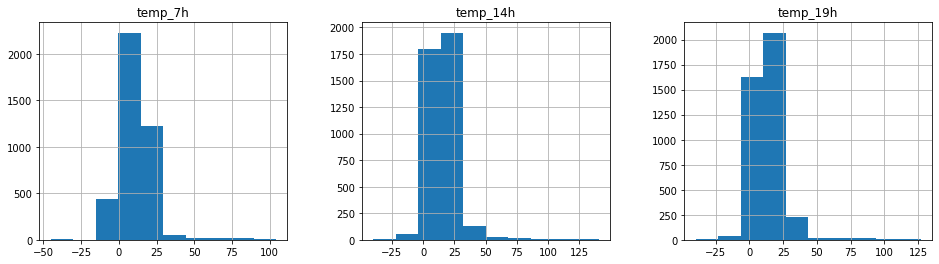

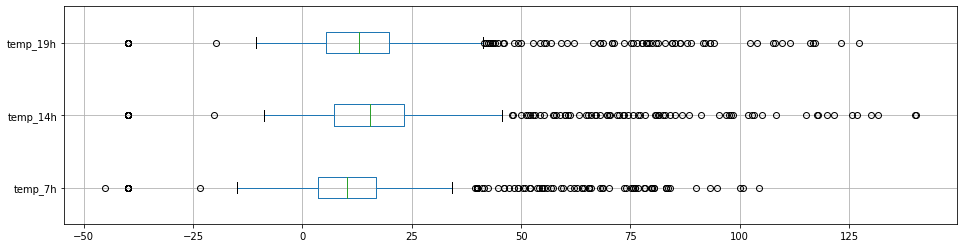

,,,,date,skyCover_7h,skyCover_14h,skyCover_19h,temp_7h,temp_14h,temp_19h,temp_dailyMean,temp_dailyMax,temp_dailyMin,hum_7h,hum_14h,hum_19h,windBeauf_7h,windBeauf_14h,windBeauf_19h,precip
year,month,week,day,,,,,,,,,,,,,,,,,
2010,2,6,8,2010-02-08,10,4,3,-40.0,-3.9,-3.55,-4.8,-3.2,-6.4,80.0,69.0,69.0,2,2,1,Spuren


,,,,date,skyCover_7h,skyCover_14h,skyCover_19h,temp_7h,temp_14h,temp_19h,temp_dailyMean,temp_dailyMax,temp_dailyMin,hum_7h,hum_14h,hum_19h,windBeauf_7h,windBeauf_14h,windBeauf_19h,precip
year,month,week,day,,,,,,,,,,,,,,,,,
2009,3,12,22,2009-03-22,5,2,10,40.0,10.7,8.1,6.2,11.3,1.1,53.0,39.0,47.0,4,4,4,0.1


In [14]:
display(data_weather_complete[["temp_7h", "temp_14h", "temp_19h"]].describe())

data_weather[["temp_7h", "temp_14h", "temp_19h"]].hist(layout=(1,3), figsize=(16,4)); plt.show()
data_weather[["temp_7h", "temp_14h", "temp_19h"]].boxplot(figsize=(16,4), vert=False); plt.show()

display(data_weather_complete[data_weather_complete.temp_7h < -20].head(1),
        data_weather_complete[data_weather_complete.temp_7h > 30].head(1))

Looking at the plots of distribution (histograms) and also boxplots (whisker plots) we see that we have some outliers in temperature values. Extremly low temperature values are clearly outliers because e.g. when `temp_7h = -40`, we have `temp_14h = -3.9`, `temp_19h = -3.55` and `temp_dailyMin = -6.4`. There is no way that the temperature will increase such rapidly for a 7h difference (`temp_7h` compared to `temp_14h`) and also `temp__7h` cannot be smaller than the daily minimum temperature `temp_dailyMin`. Same goes for other temperature columns also (`temp_14h` and `temp_19h`).

Not only for low values, we have outliers for extreme high values in the temperature columns too. An example would be the case when we have `temp_7h = 40.0"` but `temp_14h = 10.7`, `temp_19h = 8.1` and `temp_dailyMax = 11.3`. We see that for `temp_7h` we have a much higher value than we have for daily maximum temperature `temp_dailyMax`.

These temperature values can be a result of a mistake or maybe instrument failure while measuring.

In [15]:
# checking outliers using "temp_dailyMin and temp_dailyMax" and "IQR score" as lower and upper bounds respectively
# comparing the difference between these two methods for outlier detection in temperature columns
cols = ["temp_7h", "temp_14h", "temp_19h"]
for col in cols:
    temp_df = data_weather_complete[(data_weather_complete[col] < data_weather_complete.temp_dailyMin) | 
                                    (data_weather_complete[col] > data_weather_complete.temp_dailyMax)]
    Q1 = data_weather_complete[col].quantile(0.25)
    Q3 = data_weather_complete[col].quantile(0.75)
    IQR = Q3 - Q1
    Lower_bound = Q1 -(1.5 * IQR)
    Upper_bound = Q3 +(1.5 * IQR)
    iqr_df = data_weather_complete[(data_weather_complete[col] < Lower_bound) | (data_weather_complete[col] > Upper_bound)]
    diff_df = temp_df.merge(iqr_df, indicator=True, how='outer').loc[lambda x : x['_merge'] == 'right_only']
    print("\nTotal", col, "outlier values using temp_dailyMin and temp_dailyMax: ", temp_df[col].count())
    print("Total", col, "outlier values using IQR score: ", iqr_df[col].count())
    print("There are", diff_df.shape[0], "number of rows which are flagged as outliers by IQR score",
          "and not by using temp_dailyMin and temp_dailyMax")


Total temp_7h outlier values using temp_dailyMin and temp_dailyMax:  163
Total temp_7h outlier values using IQR score:  121
There are 0 number of rows which are flagged as outliers by IQR score and not by using temp_dailyMin and temp_dailyMax

Total temp_14h outlier values using temp_dailyMin and temp_dailyMax:  187
Total temp_14h outlier values using IQR score:  82
There are 0 number of rows which are flagged as outliers by IQR score and not by using temp_dailyMin and temp_dailyMax

Total temp_19h outlier values using temp_dailyMin and temp_dailyMax:  143
Total temp_19h outlier values using IQR score:  75
There are 0 number of rows which are flagged as outliers by IQR score and not by using temp_dailyMin and temp_dailyMax


To identify outlier values, data are filtered to show temperature values that are below the daily minimum temperature *(temp_dailyMin)* and above the daily maximum temperature *(temp_dailyMax)* for each of the temperature columns. Aside from this, **IQR score** method is also used to identify outliers. When comparing these two methods with each other, we can see that all of the values flagged as outliers by *IQR score* are actually contained inside the first method using minimum and maximum temperature as lower and upper bound respectively. Outliers of these temperature columns (from the first method) are then replaced with other values and not dropped entirely from the dataset. For each temperature column, we have:

```
Total temp_7h outlier values using temp_dailyMin and temp_dailyMax bounds:  163
Total temp_7h outlier values using IQR score:  121
There are 0 number of rows which are flagged as outliers by IQR score and not by using temp_dailyMin and temp_dailyMax

Total temp_14h outlier values using temp_dailyMin and temp_dailyMax bounds:  187
Total temp_14h outlier values using IQR score:  82
There are 0 number of rows which are flagged as outliers by IQR score and not by using temp_dailyMin and temp_dailyMax

Total temp_19h outlier values using temp_dailyMin and temp_dailyMax bounds:  143
Total temp_19h outlier values using IQR score:  75
There are 0 number of rows which are flagged as outliers by IQR score and not by using temp_dailyMin and temp_dailyMax
```

In [16]:
# display the correlation between temperature columns
display(data_weather_complete[["temp_7h", "temp_14h", "temp_19h", 
                               "temp_dailyMax", "temp_dailyMin", "temp_dailyMean"]].corr())

,temp_7h,temp_14h,temp_19h,temp_dailyMax,temp_dailyMin,temp_dailyMean
temp_7h,1.000000,0.536731,0.559751,0.724773,0.741799,0.745292
temp_14h,0.536731,1.000000,0.543690,0.738193,0.680099,0.726225
temp_19h,0.559751,0.543690,1.000000,0.734522,0.700006,0.732726
temp_dailyMax,0.724773,0.738193,0.734522,1.000000,0.928317,0.986803
temp_dailyMin,0.741799,0.680099,0.700006,0.928317,1.000000,0.976257
temp_dailyMean,0.745292,0.726225,0.732726,0.986803,0.976257,1.000000


In [17]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    
    cols = ["temp_7h", "temp_14h", "temp_19h"]
    replace = ["temp_dailyMin", "temp_dailyMax", "temp_dailyMean"]
    i = 0
    for col in cols:
        noisy_data.loc[((noisy_data[col] < noisy_data.temp_dailyMin) | 
                        (noisy_data[col] > noisy_data.temp_dailyMax)), col] = noisy_data.loc[((noisy_data[col] < noisy_data.temp_dailyMin) | 
                                                                                              (noisy_data[col] > noisy_data.temp_dailyMax)), replace[i]]
        i += 1
    cleaned_data = noisy_data
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

### Chosen strategy to handle outliers

Looking at the correlation table of temperature values, we see that we have correlation between temperature columns therefore to replace our outliers:
- Since `temp_7h` is the first measure of temperature during the day, it has a higher chance to actually be the lowest point of the temperature in a day. This is the reason why for replacing extreme temperature values (outliers) for `temp_7h`, `temp_dailyMin` values are used
- To replace the outliers in `temp_14h` column, values from `temp_dailyMax` are used since 14h can be the time when the temperature reachest it's highest point during the day
- To replace the outliers in `temp_19h` column, values from `temp_dailyMean` are used since during this time temperature is usually going down and could be lower than `temp_14h` but higher than `temp_7h`

## Aggregate values

Here we will aggregate observations on a weekly basis. The function below will return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: <span style="color:red">max</span> of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`
- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`
- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

In [18]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()
    data["hum_dailyMean"] = round((data.hum_7h+data.hum_14h+data.hum_19h)/3, 1)
    data.loc[data.precip == "Spuren", "precip"] = 0
    data.precip = pd.to_numeric(data.precip)
    weekly_weather_data = data.groupby(["year", "week"]).agg({'temp_dailyMin': [('temp_weeklyMin', 'min')], 
                                                              'temp_dailyMax': [('temp_weeklyMax', 'max')], 
                                                              'temp_dailyMean': [('temp_weeklyMean', 'mean')],
                                                              'temp_7h': [('temp_7h_weeklyMedian', 'median')],
                                                              'temp_14h': [('temp_14h_weeklyMedian', 'median')],
                                                              'temp_19h': [('temp_19h_weeklyMedian', 'median')],
                                                              'hum_dailyMean': [('hum_weeklyMean', 'mean')],
                                                              'hum_7h': [('hum_7h_weeklyMedian', 'median')],
                                                              'hum_14h': [('hum_14h_weeklyMedian', 'median')],
                                                              'hum_19h': [('hum_19h_weeklyMedian', 'median')],
                                                              'precip': [('precip_weeklyMean', 'mean')],
                                                              'windBeauf_14h': [('windBeauf_14h_weeklyMedian', 'median')]})
    weekly_weather_data.columns = weekly_weather_data.columns.get_level_values(1)
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

## Merge influenza and weather datasets

In [19]:
def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    
    merged_data = weather_df.merge(influenza_df, left_index=True, right_index=True)
    
    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)

## Visualization

To get a better understanding of the dataset, we will create some visualizations of the merged data set that help us to explore the potential relationships between the variables before starting to develop an actual model.

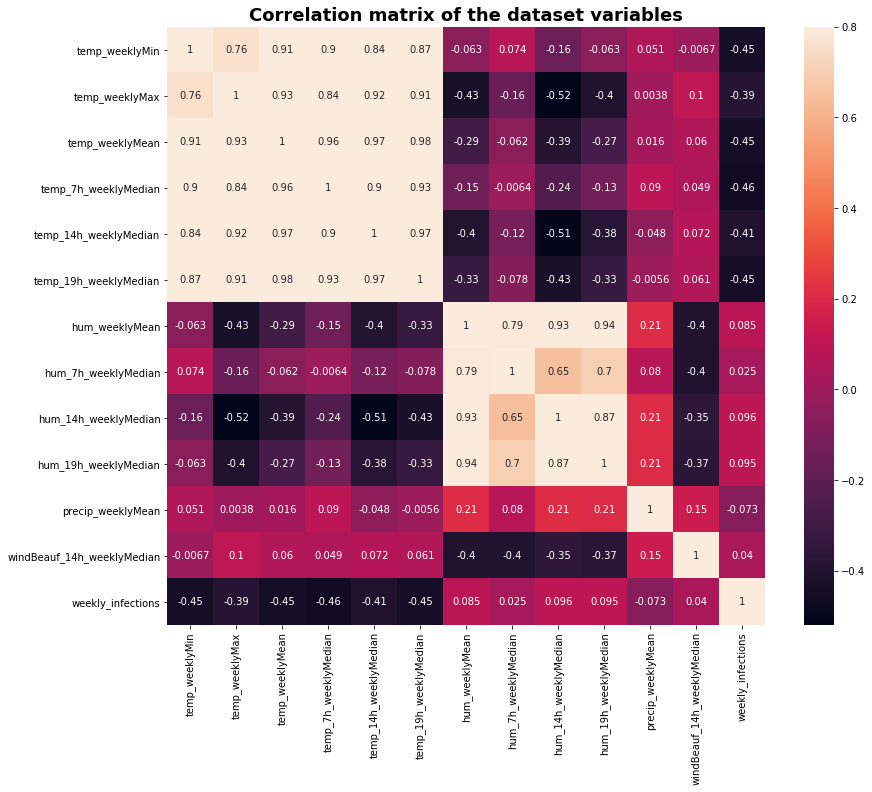

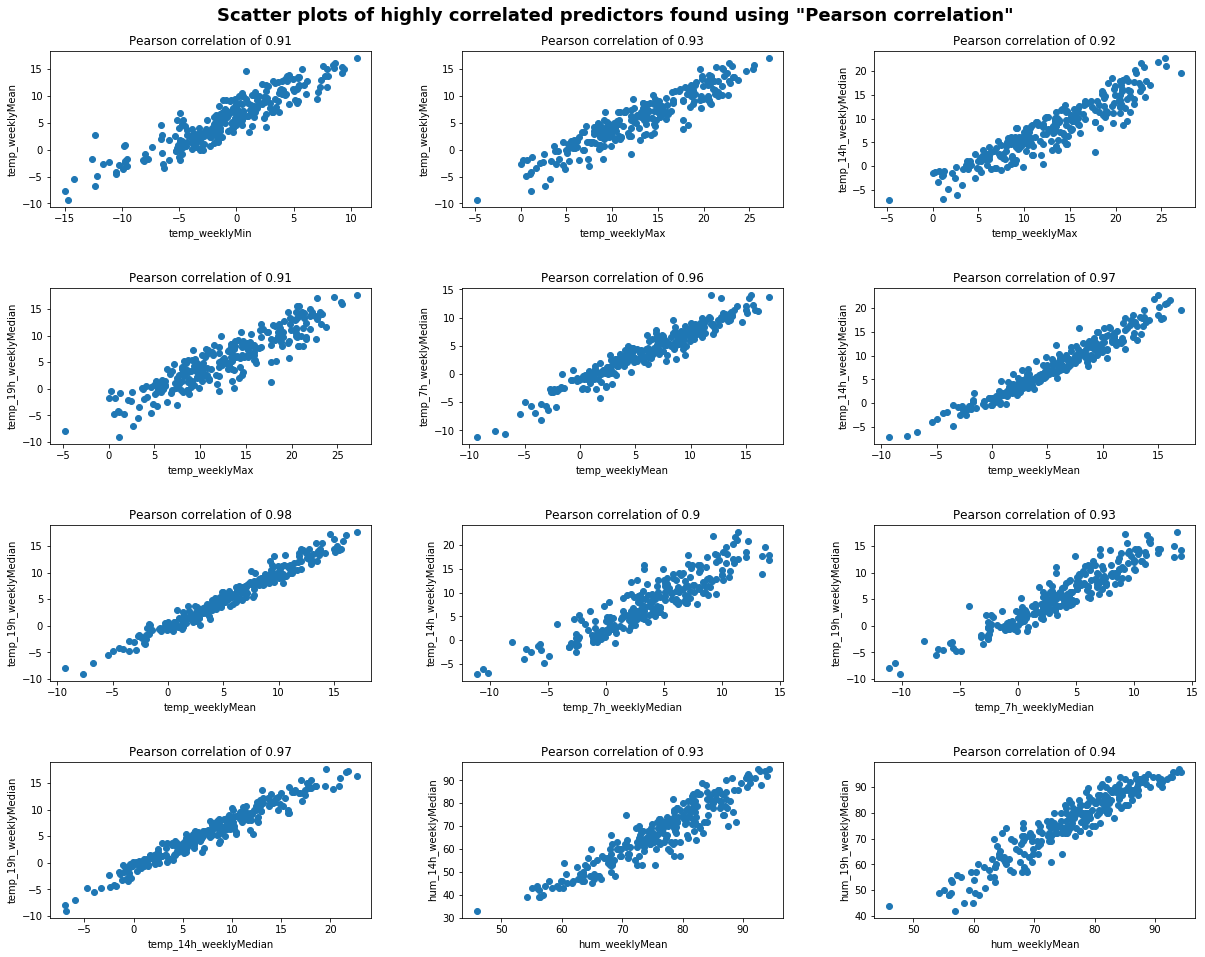

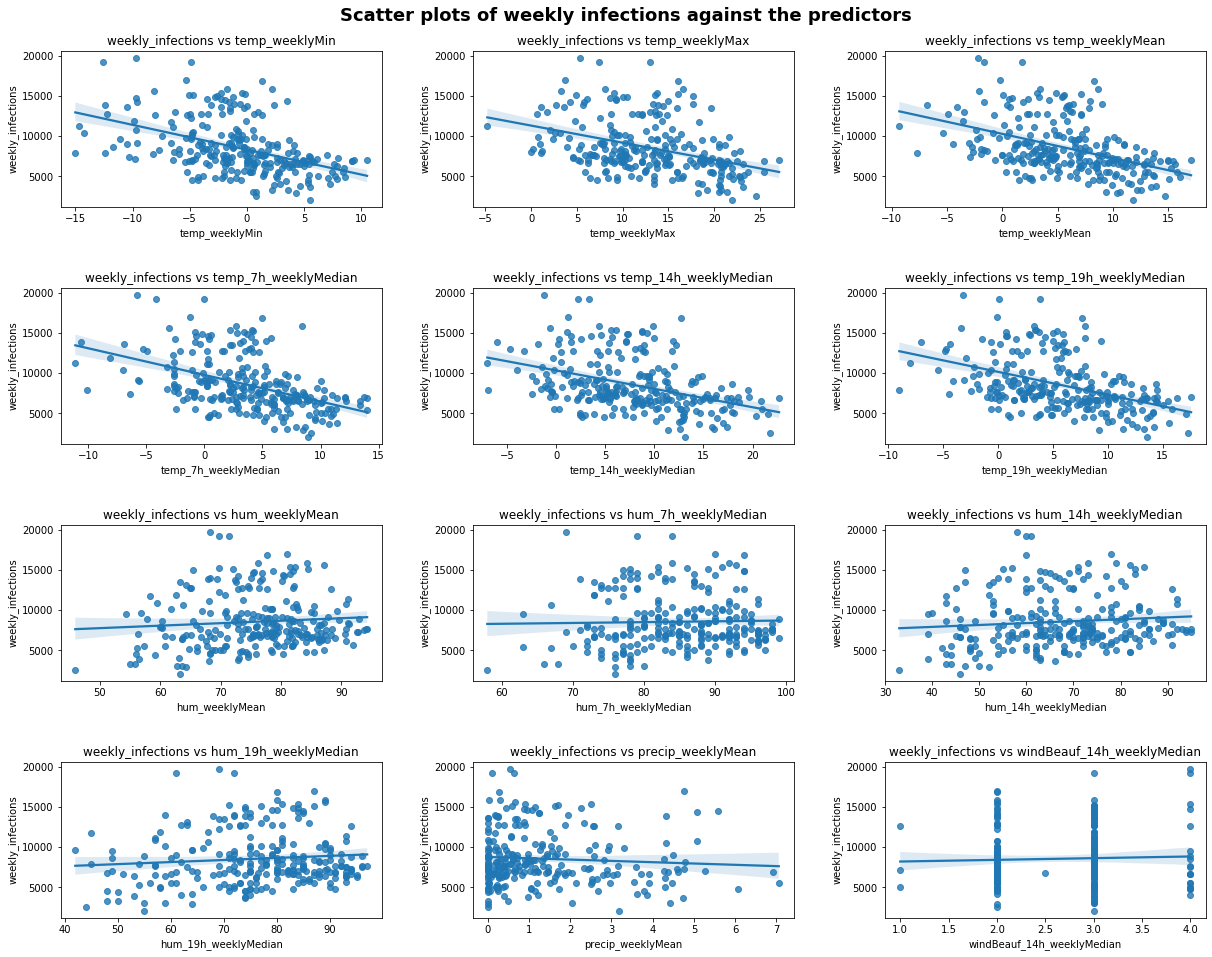

In [20]:
# correlation matrix of the data to see the relationship between the variables
correlation_matrix = data_merged.corr()
plt.figure(figsize=(14, 11))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, annot=True).set_title(
    "Correlation matrix of the dataset variables", fontsize=18, fontweight="bold")
plt.show()

# highly correlated predictors (absolute "Pearson" correlation >= 0.9)
X = data_merged.drop("weekly_infections", axis=1)
fig, ax = plt.subplots(4, 3, figsize = (18, 14))
fig.suptitle("Scatter plots of highly correlated predictors found using \"Pearson correlation\"", 
             fontsize=18, fontweight="bold")
fig.tight_layout(pad=6)
n = len(X.columns)
row = 0
col = 0
for i in range(n-1):
    for j in range(i+1,n):
        if X[X.columns[i]].dtype in ['int64','float64'] and X[X.columns[j]].dtype in ['int64','float64']:
            c = np.corrcoef(X[X.columns[i]],X[X.columns[j]])
            if abs(c[0,1])>=0.9:
                ax[row, col].scatter(X[X.columns[i]], X[X.columns[j]])
                ax[row, col].set_xlabel(str(X.columns[i]))
                ax[row, col].set_ylabel(str(X.columns[j]))
                ax[row, col].set_title("Pearson correlation of " + str(round(c[0,1], 2)))
                col += 1
                if (col == 3):
                    col = 0
                    row += 1
plt.show()

# Scatter plot of predictors with the dependent variable to see the correlation in between those
fig, ax = plt.subplots(round((len(data_merged.columns)-1) / 3), 3, figsize = (18, 14))
fig.suptitle("Scatter plots of weekly infections against the predictors", fontsize=18, fontweight="bold")
fig.tight_layout(pad=6)
for i, ax in enumerate(fig.axes):
    if i < (len(data_merged.columns)-1):
        sns.regplot(x=data_merged.columns[i],
                    y='weekly_infections', 
                    data=data_merged[data_merged.columns], 
                    ax=ax).set_title('weekly_infections vs ' + str(data_merged.columns[i]))

### Findings

From the heatmap and scatter plots of highly correlated predictors using Pearson correlation calculation, we can see that we have some high positive correlation between predictors. Weekly average temperature is highly positive correlated with weekly median of temperatures at 7h, 14h and 19h (which is to be expected) and also weekly average humidity is highly positive correlated with weekly median of humidity at 7h, 14h and 19h. Overall, all temperature variable are correlated with each other and the same goes also for humidity variables.

Some of the predictors are also correlated with dependent variable. We see that temperature values have more influenze in weekly infections than humidity and the correlation is negative. This indicates that when the temperatures are lower, there is a higher chance for us to get infected and vice-versa. Also, one can detect the high variance (heteroscedasticity) in weekly infections vs predictors scatter plots depicted in the above pictures.

precip_weeklyMean and windBeauf_14h variables seem to have a very small or no correlation at all with the dependent variable, with windBeauf_14h having a very small number of possible values (only 5).

It will depend on the algorithm chosen but highly correlated variables can have a negative effect in the model therefore should be taken care of. Although, choosing an algorithm that is robust to highly correlated predictors can be beneficial in this case.

## Influenza prediction model

Now we will build a model to predict the number of influenza incidents for the first part of the 2019/<span style="color:red">2020</span> Influenza season (`influenza_predict.csv`) based on data of previous years using `sklearn`. 

To build our model, we will go through these steps:

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure our results are reproducible (by setting a seed number)
 - Tune models parameter by using 10-fold cross-validation
 - Experiment with different training/test splits
 - Try different scaling approaches (min/max, z-score,..) and check their effect in prediction
 - Check how good does our model fit when we evaluate it with the test data set?
 - Check how good are the predictions when we use just the data for 2019 in `influenza.csv` to train our model?


 					 PLS 


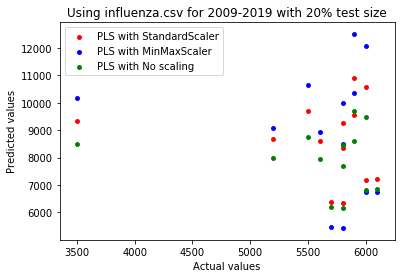

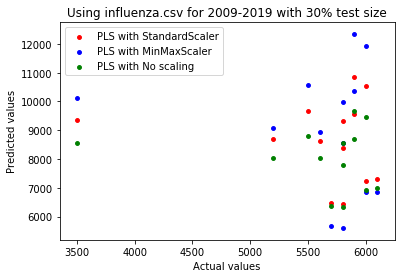

,n_components,CV RMSE,MAE,RMSE of test set,Test data set RMSE,Model tuning time (s),Model,Scaling method,Test set size (%)
0,1,3021.758906,2405.213912,2918.895732,3443.125174,4.088002,PLS,StandardScaler,20
0,1,3021.758906,2405.213912,2918.895732,4152.693677,0.359003,PLS,MinMaxScaler,20
0,1,3021.758906,2405.213912,2918.895732,2702.963380,0.940006,PLS,No scaling,20
0,1,2999.664059,2374.541159,3055.427994,3452.180034,0.355987,PLS,StandardScaler,30
0,1,2999.664059,2374.541159,3055.427994,4101.901624,0.338002,PLS,MinMaxScaler,30
0,1,2999.664059,2374.541159,3055.427994,2747.106253,0.609000,PLS,No scaling,30


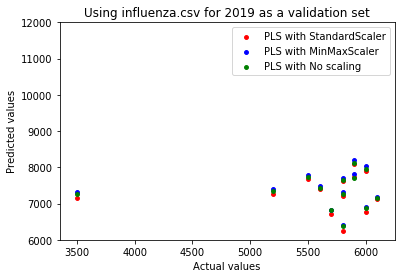

,n_components,CV RMSE,MAE,Test data set RMSE,Model tuning time (s),Model,Scaling method
0,1,2351.247915,2217.456373,1871.440550,0.328999,PLS,StandardScaler
0,1,2351.247915,2217.456373,1974.569483,0.325527,PLS,MinMaxScaler
0,1,2351.247915,2217.456373,1924.801100,0.670004,PLS,No scaling



 					 Ridge 


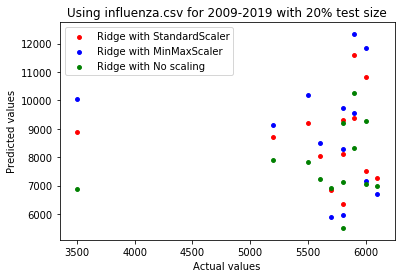

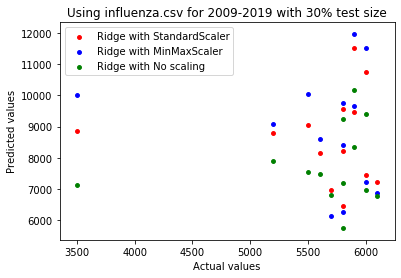

,alpha,fit_intercept,CV RMSE,MAE,RMSE of test set,Test data set RMSE,Model tuning time (s),Model,Scaling method,Test set size (%)
0,9.99,True,3076.989204,2398.504308,2765.073584,3418.286645,34.085597,Ridge,StandardScaler,20
0,6.41,True,3037.219830,2387.028755,2873.554668,3937.294395,36.675317,Ridge,MinMaxScaler,20
0,9.99,False,3126.266714,2451.051598,2716.259318,2467.766940,98.176956,Ridge,No scaling,20
0,9.99,True,3059.623209,2389.845265,2967.447970,3430.803640,34.963684,Ridge,StandardScaler,30
0,7.97,True,3013.448244,2363.290058,3054.542240,3859.252048,38.358516,Ridge,MinMaxScaler,30
0,9.99,False,3077.836342,2425.652702,2972.759796,2486.587477,93.963753,Ridge,No scaling,30


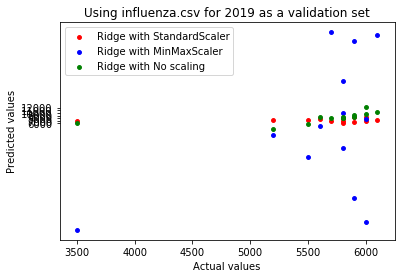

,alpha,fit_intercept,CV RMSE,MAE,Test data set RMSE,Model tuning time (s),Model,Scaling method
0,9.99,True,2497.897356,2328.071875,1893.479274,40.967588,Ridge,StandardScaler
0,-0.89,True,2084.993215,1998.816379,23998.234962,40.992919,Ridge,MinMaxScaler
0,9.99,False,3018.292045,2827.501550,3135.104848,99.093548,Ridge,No scaling



 					 Random Forest 


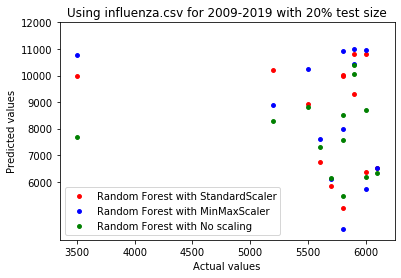

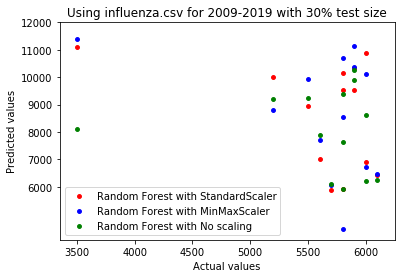

,n_estimators,CV RMSE,MAE,RMSE of test set,Test data set RMSE,Model tuning time (s),Model,Scaling method,Test set size (%)
0,1000,3165.093729,2455.245524,2785.397527,3674.857622,29.212907,Random Forest,StandardScaler,20
0,1000,3165.640266,2454.408333,2780.981083,3904.770774,32.937598,Random Forest,MinMaxScaler,20
0,1000,3166.761566,2453.871786,2782.316558,2727.712656,31.062114,Random Forest,No scaling,20
0,1000,3218.044463,2508.918333,2963.794217,3777.390184,29.502750,Random Forest,StandardScaler,30
0,1000,3222.219259,2515.235556,2947.569312,3903.641757,30.735229,Random Forest,MinMaxScaler,30
0,1000,3227.508399,2518.307222,2945.725983,2973.540289,29.365657,Random Forest,No scaling,30


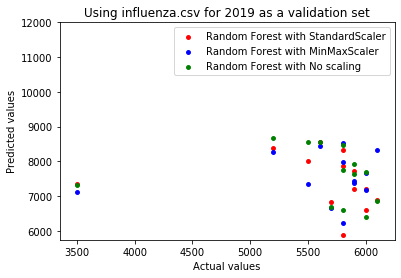

,n_estimators,CV RMSE,MAE,Test data set RMSE,Model tuning time (s),Model,Scaling method
0,1000,2446.426999,2347.320,2136.881796,22.192463,Random Forest,StandardScaler
0,1000,2442.407675,2342.665,2159.939292,22.489138,Random Forest,MinMaxScaler
0,1000,2440.973100,2340.945,2286.529982,23.364930,Random Forest,No scaling


In [21]:
# setting seed for reproducibility
seed = 123

# load influenza_predict.csv & merge it with data_weather_weekly
data_path = "./data/influenza/influenza_predict.csv"
influenza_predict = pd.read_csv(data_path, usecols=["Jahr", "Kalenderwoche", "Neuerkrankungen pro Woche"])
# remove . Woche from each record in Kalenderwoche column and convert it to numeric type
influenza_predict["Kalenderwoche"] = pd.to_numeric(influenza_predict["Kalenderwoche"].str.replace(". Woche", ""))
influenza_predict.rename(columns={"Jahr": "year",
                                  "Kalenderwoche": "week",
                                  "Neuerkrankungen pro Woche": "weekly_infections"}, inplace=True)
influenza_predict.set_index(["year", "week"], inplace=True)
influenza_predict["weekly_infections"] = pd.to_numeric(influenza_predict["weekly_infections"])
test_data = data_weather_weekly.merge(influenza_predict, left_index=True, right_index=True)

# create X and y
drop_cols = ["weekly_infections"]
X = data_merged.drop(drop_cols, axis=1)
y = data_merged.weekly_infections

# Split test data and validation data into training and test sets
X_pred = test_data.drop(drop_cols, axis=1)
y_pred = test_data.weekly_infections
X_val = data_merged[data_merged.index.get_level_values(0) == 2019].drop(drop_cols, axis=1)
y_val = data_merged[data_merged.index.get_level_values(0) == 2019].weekly_infections
# scale the data using StandardScaler
scaler = preprocessing.StandardScaler()
X_pred_ss = scaler.fit_transform(X_pred)
X_val_ss = scaler.fit_transform(X_val)
# scale the data using MinMaxScaler
minmax = preprocessing.MinMaxScaler()
X_pred_mm = minmax.fit_transform(X_pred)
X_val_mm = minmax.fit_transform(X_val)
# create scaling dictionary with different scaling techniques
scalingValidation = [("StandardScaler", X_val_ss, y_val, X_pred_ss, y_pred),
                     ("MinMaxScaler", X_val_mm, y_val, X_pred_mm, y_pred),
                     ("No scaling", X_val, y_val, X_pred, y_pred)]

# different coloring based on scaling techniques for plotting the results at the end
colormap = {"StandardScaler": 'r',
            "MinMaxScaler": 'b',
            "No scaling": 'g'}

# create scoring dictionary with different evaluation methods
scoring = {'RMSE': "neg_root_mean_squared_error",
           'MAE': "neg_mean_absolute_error"}

# set parameters that will be tuned using GridSearchCV
paramGridPLS = dict(n_components=range(1, X.shape[1]+1))
paramGridRidge = dict(alpha=np.arange(-2, 10, 0.01), fit_intercept=np.array([False, True]))
paramGridRF = dict(n_estimators=[100, 500, 1000])
# set models that will be used
models = [("PLS", PLSRegression(), paramGridPLS),
          ("Ridge", Ridge(random_state=seed), paramGridRidge),
          ("Random Forest", RandomForestRegressor(random_state=seed, n_jobs=-1), paramGridRF)]

# 10-fold cross-validation
cv_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)

# Split "influenza.csv" training data into multiple training and test sets
split_sizes = [0.2, 0.3]
for label, model, params in models:
    print("\n========================================================================================\n",
          "\t\t\t\t\t", label,
          "\n========================================================================================")
    model_df = pd.DataFrame()
    for split_size in split_sizes:
        X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=split_size, random_state=seed)
        # scale the data using StandardScaler
        scaler = preprocessing.StandardScaler()
        X_train_ss = scaler.fit_transform(X_train)
        X_test_ss = scaler.transform(X_test)
        # scale the data using MinMaxScaler
        minmax = preprocessing.MinMaxScaler()
        X_train_mm = minmax.fit_transform(X_train)
        X_test_mm = minmax.transform(X_test)
        # create scaling dictionary with different scaling techniques
        scalingTrain = [("StandardScaler", X_train_ss, y_train, X_test_ss, y_test, X_pred_ss, y_pred),
                        ("MinMaxScaler", X_train_mm, y_train, X_test_mm, y_test, X_pred_mm, y_pred),
                        ("No scaling", X_train, y_train, X_test, y_test, X_pred, y_pred)]
        ######################################################################################################
        #            Check how good does our model fit when we evaluate it with the test data set?           #
        ######################################################################################################
        for scale, X_train, y_train, X_test, y_test, X_pred, y_pred in scalingTrain:
            t0 = time.time()
            grid = model_selection.GridSearchCV(estimator=model,
                                                param_grid=params,
                                                cv=cv_10,
                                                scoring=scoring,
                                                refit="RMSE",
                                                n_jobs=-1)
            grid_results = grid.fit(X_train, y_train)
            tuning_time = time.time() - t0
            results = pd.DataFrame(grid_results.cv_results_['params'])
            results['CV RMSE'] = abs(grid_results.cv_results_['mean_test_RMSE'])
            results['MAE'] = abs(grid_results.cv_results_['mean_test_MAE'])
            results['RMSE of test set'] = abs(grid_results.score(X_test, y_test))
            results['Test data set RMSE'] = abs(grid_results.score(X_pred, y_pred))
            results['Model tuning time (s)'] = tuning_time
            results['Model'] = label
            results['Scaling method'] = scale
            results['Test set size (%)'] = int(split_size * 100)
            results = results[(results["CV RMSE"] == abs(grid_results.best_score_))].sort_values("CV RMSE", ascending=True).reset_index(drop = True)
            model_df = pd.concat([model_df, results.head(1)])
            plt.scatter(y_pred, grid_results.predict(X_pred), label=str(label + " with " + scale), c=colormap[scale], s=15)
            plt.xlabel("Actual values")
            plt.ylabel("Predicted values")
            plt.xticks(np.arange(3500, 6500, 500))
            plt.yticks(np.arange(6000, 13000, 1000))
            plt.title("Using influenza.csv for 2009-2019 with " + str(int(split_size * 100)) + "% test size")
        plt.legend(loc='best')
        plt.show()
    display(model_df)
    ##############################################################################################################
    # Check how good are the predictions when we use just the data for 2019 in influenza.csv to train our model? #
    ##############################################################################################################
    model_df = pd.DataFrame()
    for scale, X_train, y_train, X_pred, y_pred in scalingValidation:
        t0 = time.time()
        grid = model_selection.GridSearchCV(estimator=model,
                                            param_grid=params,
                                            cv=cv_10,
                                            scoring=scoring,
                                            refit="RMSE",
                                            n_jobs=-1)
        grid_results = grid.fit(X_train, y_train)
        tuning_time = time.time() - t0
        results = pd.DataFrame(grid_results.cv_results_['params'])
        results['CV RMSE'] = abs(grid_results.cv_results_['mean_test_RMSE'])
        results['MAE'] = abs(grid_results.cv_results_['mean_test_MAE'])
        results['Test data set RMSE'] = abs(grid_results.score(X_pred, y_pred))
        results['Model tuning time (s)'] = tuning_time
        results['Model'] = label
        results['Scaling method'] = scale
        results = results[(results["CV RMSE"] == abs(grid_results.best_score_))].sort_values("CV RMSE", ascending=True).reset_index(drop = True)
        model_df = pd.concat([model_df, results.head(1)])
        plt.scatter(y_pred, grid_results.predict(X_pred), label=str(label + " with " + scale), c=colormap[scale], s=15)
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.xticks(np.arange(3500, 6500, 500))
        plt.yticks(np.arange(6000, 13000, 1000))
        plt.title("Using influenza.csv for 2019 as a validation set")
    plt.legend(loc='best')
    plt.show()
    display(model_df)

### Approach and algorithm(s)

Since we are dealing with a regression problem here, the following regression models are used to predict the weekly infections:
- Partial Least Squares
- Ridge Regression
- Random Forest Regression

Taking into account the insights from task 6 that temperature predictors are highly positive correlated with each other and the same goes also for humidity predictors, **Partial Least Squares** model is used. The intention of this model is that the chosen latent variables are relevant not only for X (independent variable(s)), but also for y (dependent variable). As can be seen from the results we have got above, *PLS* method is very quick and efficient compared to the other methods. In almost all the cases, *PLS* took less than a second to tune the best model.

**Ridge Regression** is used because it performs well when we have the problem of correlated predictors in our dataset. By shrinking coefficients of variables which contribute less to the model, *Ridge* allows us to use complex models and avoid overfitting at the same time. In order to shrink those coefficients, *Ridge* uses `L2 regularization` which adds an L2 penalty. By doing this, all coefficients are shrunk by the same factor therefore none are eliminated completely from the model. While trying to find the optimal *alpha* value (regularization parameter) for the model, tunning took much longer time compared to *PLS*.

**Random Forest Regreesion** model is used because it can handle different types of features, the data does not need to be scaled or transformed, it is robust to outliers, handles unbalanced datasets and can avoid overfitting by changing the number of estimators used to build the trees. *Random Forests* select a new subset of variables to grow for each tree therefore it is less probable that the collinear terms will be both selected. In the end, the overall prediction will be based on the average prediction of all the tree in the forest.

To experiment with our selected models, these training/test sets sizes are used:
- 80% for training and 20% for testing
- 70% for training and 30% for testing

and the following scaling techniques:
1. StandardScaler
2. MinMaxScaler
3. No scaling

In order to tune best parameters for our models, `GridSearchCV` with `10-fold cross-validation` method is used. Parameters used to be tunned are:
- **PLS**: n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
- **Ridge Regression**: alpha = {range from -2 to 10 with 0.01 step} and fit_intercept = [True, False]
- **Random Forest Regreesion**: n_estimators = [100, 500, 1000]

Since we have three regression models, for each model, training data is first split into train/test sets. After splitting, for each scaling technique, a GridSearchCV with 10-fold cross-validation is used to find the best parameters for our model. In order to find the best parameters, GridSearchCV requires at least one evaluation metric therefore in our case two of them are used:
- Root Mean Squared Error (RMSE)
    - Choosen because RMSE penalizes large errors but minimizes small ones
- Mean Absolute Error (MAE)
    - Choosen because MAE is more robust to outliers since it does not make use of square

Since both of these evaluation metrics calculate the model prediction error *(y_true - y_pred)*, in order to find the best parameters for our model, we need to minimize them.

### Findings

Overall, none of the models build produced valuable results that can be used in the future to predict weekly infections. All of the results were really bad with RMSE and MAE extremely high. This can also be seen by looking at the plots of `Actual values vs Predicted values` of the models. From the plots we also see data points distribution of the test set which are close to each other (low variance) except for 3 data points, which are somehow separated from others therefore forming like two separated clusters of points (one to the left and the other to the right).

Taking into account that three different scaling techniques are used (StandardScaler, MinMaxScaler and No scaling), No scaling approach gave the best results in each of the cases when tested for different models and different train/test splits, using `influenza.csv` 2009-2019 dataset. However, when using only 2019 data as a validation set, StandardScaler gave the best results, but was not so different for the other two techniques (especially in the case of Random Forest Regression).

Since two train/test splits are used, when 80% of the whole dataset (2009-2019) is used for training, models were fitted better, having smaller `RMSE` when predicting unseen data of `influenza_predict.csv` compared to when 70% of the whole dataset was used.

Comparing the results of our models when trained using the whole 2009-2019 set vs when using only 2019, we see that they predicted better the testing set of `influenza_predict.csv` when only 2019 data was used. *PLS* with 1 component (`n_components=1`) and a `RMSE` of `1871.440550` on the test set, performed the best, with a slightly better performance than *Ridge* with `alpha=9.99` and `fit_intercept=true`. From this we can derive that using the recent weather informations can result in better prediction for the upcoming weekly infections.